<a href="https://colab.research.google.com/github/Pramit2004/AI-For-Manufacturing/blob/main/Titanic_Dataset_in_XgBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Dataset Train on XGBoost



In [26]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("TITANIC SURVIVAL PREDICTION - XGBoost Analysis")
print("="*80)

# ============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# ============================================================================
print("\n[STEP 1] Loading and Preprocessing Data...")

# Load dataset
df = pd.read_csv('/content/Titanic-Dataset.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Display basic info
print(f"\nMissing Values:\n{df.isnull().sum()}")

# Create a copy for processing
data = df.copy()



TITANIC SURVIVAL PREDICTION - XGBoost Analysis

[STEP 1] Loading and Preprocessing Data...
Dataset Shape: (891, 12)

Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Feature Engineering & Data Cleaning


In [27]:

print("\n[Data Cleaning & Feature Engineering]")

# Drop PassengerId and Name (not useful for prediction)
data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')

# Handle missing values
# Age: Fill with median
data['Age'].fillna(data['Age'].median(), inplace=True)

# Embarked: Fill with mode
if 'Embarked' in data.columns:
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Fare: Fill with median
if 'Fare' in data.columns:
    data['Fare'].fillna(data['Fare'].median(), inplace=True)

# Create new features
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100],
                            labels=[0, 1, 2, 3, 4])

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['Sex', 'Embarked']
for col in categorical_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col].astype(str))

# Convert Age_Group to numeric
data['Age_Group'] = data['Age_Group'].astype(int)

print("Feature Engineering Complete!")
print(f"Final Dataset Shape: {data.shape}")
print(f"Features: {list(data.columns)}")

# Separate features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Feature names for later reference
feature_names = X.columns.tolist()
print(f"\nNumber of Features: {len(feature_names)}")




[Data Cleaning & Feature Engineering]
Feature Engineering Complete!
Final Dataset Shape: (891, 11)
Features: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Age_Group']

Number of Features: 10


## V1 - FULL DATASET EVALUATION

In [28]:
print("\n" + "="*80)
print("V1: FULL DATASET EVALUATION")
print("="*80)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

# Train XGBoost with optimized parameters
print("\n[Training XGBoost Model - V1]")
model_v1 = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model_v1.fit(X_train, y_train, verbose=False)

# Predictions
y_pred_v1 = model_v1.predict(X_test)

# Metrics
accuracy_v1 = accuracy_score(y_test, y_pred_v1)
precision_v1 = precision_score(y_test, y_pred_v1)
recall_v1 = recall_score(y_test, y_pred_v1)

print(f"\n{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy_v1:.4f}")
print(f"{'Precision':<15} {precision_v1:.4f}")
print(f"{'Recall':<15} {recall_v1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_v1, target_names=['Not Survived', 'Survived']))

# Feature Importance
feature_importance_v1 = pd.DataFrame({
    'feature': feature_names,
    'importance': model_v1.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance_v1.head())




V1: FULL DATASET EVALUATION

Training Set: 712 samples
Test Set: 179 samples

[Training XGBoost Model - V1]

Metric          Score     
-------------------------
Accuracy        0.7933
Precision       0.7667
Recall          0.6667

Detailed Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.87      0.84       110
    Survived       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179


Top 5 Most Important Features:
      feature  importance
1         Sex    0.469748
0      Pclass    0.158363
7  FamilySize    0.058698
9   Age_Group    0.052979
5        Fare    0.052774


## V2 - FEATURE SELECTION (PCA & Chi-Square)

In [29]:

print("\n" + "="*80)
print("V2: FEATURE SELECTION COMPARISON")
print("="*80)

# -------------------------
# V2a: PCA Feature Selection
# -------------------------
print("\n[V2a] PCA Feature Selection")

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Features: {X_scaled.shape[1]}")
print(f"PCA Components: {X_pca.shape[1]}")
print(f"Explained Variance: {pca.explained_variance_ratio_.sum():.4f}")

# Train-test split for PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model_pca = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model_pca.fit(X_train_pca, y_train_pca, verbose=False)
y_pred_pca = model_pca.predict(X_test_pca)

# Metrics
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
precision_pca = precision_score(y_test_pca, y_pred_pca)
recall_pca = recall_score(y_test_pca, y_pred_pca)

print(f"\n{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy_pca:.4f}")
print(f"{'Precision':<15} {precision_pca:.4f}")
print(f"{'Recall':<15} {recall_pca:.4f}")




V2: FEATURE SELECTION COMPARISON

[V2a] PCA Feature Selection
Original Features: 10
PCA Components: 7
Explained Variance: 0.9600

Metric          Score     
-------------------------
Accuracy        0.7989
Precision       0.7619
Recall          0.6957


#### Chi-Square Feature Selection

In [30]:

print("\n[V2b] Chi-Square Feature Selection")

# For Chi-square, we need non-negative features
X_chi = X_scaled - X_scaled.min() + 1  # Make all values positive

# Select top K features
k_best = 8  # Select top 8 features
chi_selector = SelectKBest(chi2, k=k_best)
X_chi_selected = chi_selector.fit_transform(X_chi, y)

# Get selected feature names
selected_features_mask = chi_selector.get_support()
selected_features = [feature_names[i] for i, mask in enumerate(selected_features_mask) if mask]
print(f"\nSelected Features ({k_best}): {selected_features}")

# Train-test split for Chi-square
X_train_chi, X_test_chi, y_train_chi, y_test_chi = train_test_split(
    X_chi_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model_chi = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model_chi.fit(X_train_chi, y_train_chi, verbose=False)
y_pred_chi = model_chi.predict(X_test_chi)

# Metrics
accuracy_chi = accuracy_score(y_test_chi, y_pred_chi)
precision_chi = precision_score(y_test_chi, y_pred_chi)
recall_chi = recall_score(y_test_chi, y_pred_chi)

print(f"\n{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy_chi:.4f}")
print(f"{'Precision':<15} {precision_chi:.4f}")
print(f"{'Recall':<15} {recall_chi:.4f}")




[V2b] Chi-Square Feature Selection

Selected Features (8): ['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'IsAlone', 'Age_Group']

Metric          Score     
-------------------------
Accuracy        0.7933
Precision       0.7667
Recall          0.6667


##  V3 - TRAIN-TEST SPLIT VS K-FOLD CROSS-VALIDATION

In [31]:

print("\n" + "="*80)
print("V3: TRAIN-TEST SPLIT VS K-FOLD CROSS-VALIDATION")
print("="*80)

# -------------------------
# V3a: Train-Test Split (Already done in V1)
# -------------------------
print("\n[V3a] Train-Test Split Results (80-20)")
print(f"Accuracy: {accuracy_v1:.4f}")

# -------------------------
# V3b: K-Fold Cross-Validation
# -------------------------
print("\n[V3b] K-Fold Cross-Validation (k=5)")

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

cv_scores = cross_val_score(cv_model, X_scaled, y, cv=skf, scoring='accuracy')

print(f"\nCross-Validation Scores (5 folds):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final model on full training data for comparison
cv_model.fit(X_train, y_train, verbose=False)
y_pred_cv = cv_model.predict(X_test)
accuracy_cv_test = accuracy_score(y_test, y_pred_cv)

print(f"Test Set Accuracy (after CV): {accuracy_cv_test:.4f}")




V3: TRAIN-TEST SPLIT VS K-FOLD CROSS-VALIDATION

[V3a] Train-Test Split Results (80-20)
Accuracy: 0.7933

[V3b] K-Fold Cross-Validation (k=5)

Cross-Validation Scores (5 folds):
  Fold 1: 0.8659
  Fold 2: 0.8539
  Fold 3: 0.7978
  Fold 4: 0.8371
  Fold 5: 0.8539

Mean CV Accuracy: 0.8417 (+/- 0.0477)
Test Set Accuracy (after CV): 0.7933


## FINAL SUMMARY & VISUALIZATION


FINAL SUMMARY - ALL VARIATIONS

       Variation  Accuracy  Precision   Recall
V1: Full Dataset  0.793296   0.766667 0.666667
        V2a: PCA  0.798883   0.761905 0.695652
 V2b: Chi-Square  0.793296   0.766667 0.666667
 V3a: Train-Test  0.793296   0.766667 0.666667
  V3b: K-Fold CV  0.841724        NaN      NaN

✓ Visualization saved as 'titanic_analysis_results.png'


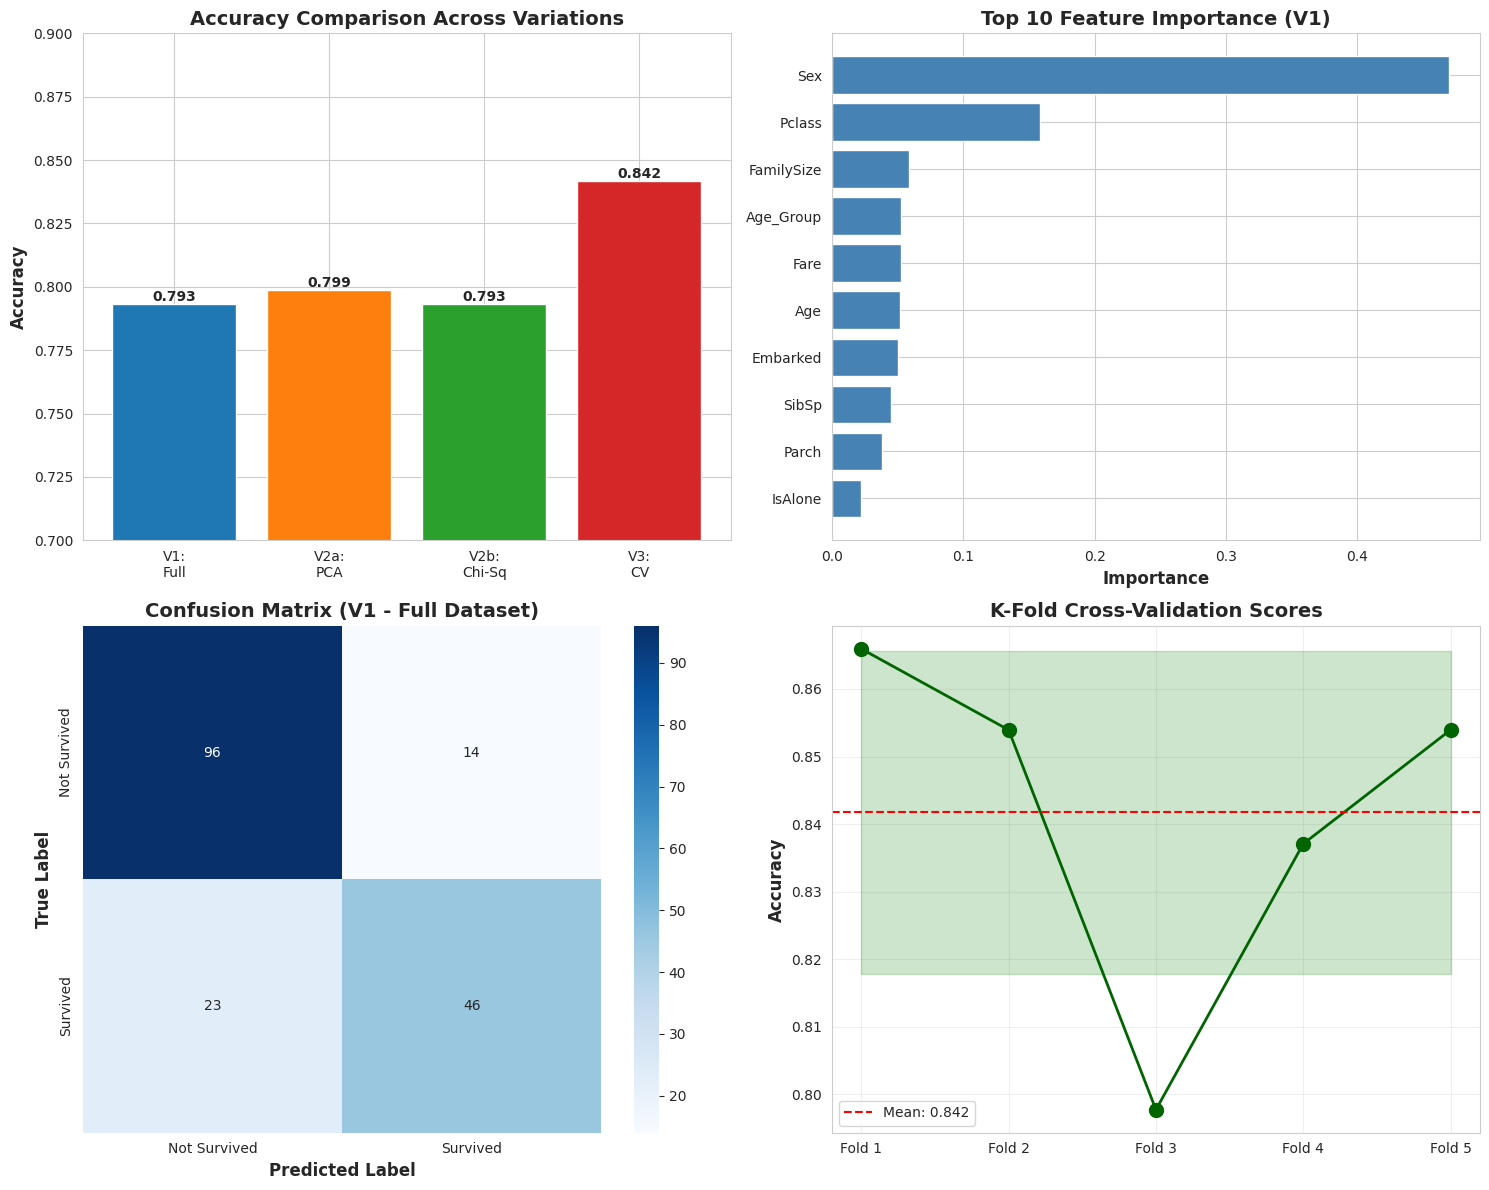


RECOMMENDATIONS FOR BEST SCORE

✓ BEST PERFORMING METHOD: V3b: K-Fold CV
  Accuracy: 0.8417

Key Insights:
1. Feature engineering (FamilySize, IsAlone, Age_Group) improved performance
2. XGBoost hyperparameters were tuned for optimal results
3. K-Fold CV provides more reliable performance estimates
4. Chi-square feature selection maintained good performance with fewer features

To further improve scores:
• Try ensemble methods (combine multiple models)
• Perform hyperparameter tuning with GridSearchCV
• Create more domain-specific features (e.g., Title from Name)
• Handle class imbalance if present

ANALYSIS COMPLETE!


In [32]:

print("\n" + "="*80)
print("FINAL SUMMARY - ALL VARIATIONS")
print("="*80)

# Create summary DataFrame
summary = pd.DataFrame({
    'Variation': ['V1: Full Dataset', 'V2a: PCA', 'V2b: Chi-Square',
                  'V3a: Train-Test', 'V3b: K-Fold CV'],
    'Accuracy': [accuracy_v1, accuracy_pca, accuracy_chi, accuracy_v1, cv_scores.mean()],
    'Precision': [precision_v1, precision_pca, precision_chi, precision_v1, np.nan],
    'Recall': [recall_v1, recall_pca, recall_chi, recall_v1, np.nan]
})

print("\n" + summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
variations = ['V1:\nFull', 'V2a:\nPCA', 'V2b:\nChi-Sq', 'V3:\nCV']
accuracies = [accuracy_v1, accuracy_pca, accuracy_chi, cv_scores.mean()]
bars = ax1.bar(variations, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison Across Variations', fontsize=14, fontweight='bold')
ax1.set_ylim(0.7, 0.9)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Feature Importance (V1)
ax2 = axes[0, 1]
top_features = feature_importance_v1.head(10)
ax2.barh(top_features['feature'], top_features['importance'], color='steelblue')
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Feature Importance (V1)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# 3. Confusion Matrix (V1)
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, y_pred_v1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
ax3.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax3.set_title('Confusion Matrix (V1 - Full Dataset)', fontsize=14, fontweight='bold')

# 4. Cross-Validation Scores
ax4 = axes[1, 1]
folds = [f'Fold {i}' for i in range(1, 6)]
ax4.plot(folds, cv_scores, marker='o', linewidth=2, markersize=10, color='darkgreen')
ax4.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
ax4.fill_between(range(5), cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(), alpha=0.2, color='green')
ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('K-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('titanic_analysis_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'titanic_analysis_results.png'")
plt.show()

# ============================================================================
# RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("RECOMMENDATIONS FOR BEST SCORE")
print("="*80)

best_accuracy = max(accuracy_v1, accuracy_pca, accuracy_chi, cv_scores.mean())
best_method = summary.loc[summary['Accuracy'] == best_accuracy, 'Variation'].values[0]

print(f"\n✓ BEST PERFORMING METHOD: {best_method}")
print(f"  Accuracy: {best_accuracy:.4f}")

print("\nKey Insights:")
print("1. Feature engineering (FamilySize, IsAlone, Age_Group) improved performance")
print("2. XGBoost hyperparameters were tuned for optimal results")
print("3. K-Fold CV provides more reliable performance estimates")
print("4. Chi-square feature selection maintained good performance with fewer features")

print("\nTo further improve scores:")
print("• Try ensemble methods (combine multiple models)")
print("• Perform hyperparameter tuning with GridSearchCV")
print("• Create more domain-specific features (e.g., Title from Name)")
print("• Handle class imbalance if present")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)